# Medical Report Generation
Author: Ruchit Agrawal

- Now we will demonstrate how we can use the ChexNet model to generate a medical report from an input Chest X-ray image.


### Example Medical report
![](https://www.researchgate.net/profile/Le-Lu-9/publication/301837242/figure/fig1/AS:360967612452868@1463072793919/An-example-of-OpenI-2-chest-x-ray-image-report-and-annotations.png)

---
### Other text reports from database 

1)



 Comparison:  two view chest from

 Indication:  year old male with

 Findings:  heart size within normal limits . mild hyperinflation of the lungs . mild pectus excavatum deformity . stable left mid lung calcified granuloma . no focal airspace disease . no pneumothorax or effusions .

 Impression:  changes of chronic lung disease with no acute cardiopulmonary finding . 

 ****************************************************************************************************************************************************** 


2)



 Comparison:  none .

 Indication:  chest ray positvie tb . language unable to get more hx

 Findings:  nan

 Impression:  normal heart size . normal pulmonary vasculature . normal mediastinal contours . lung parenchyma is clear . no airspace disease . no pulmonary edema . no of pleural effusions . no of active tuberculosis . no of active cardiopulmonary disease . 

 ****************************************************************************************************************************************************** 


3)



 Comparison:  none

 Indication:  chest radiograph prior to initiation of medication

 Findings:  the lungs appear clear . the heart and pulmonary are normal . mediastinal contours are normal . the pleural spaces are clear .

 Impression:  no acute cardiopulmonary disease . 

 ****************************************************************************************************************************************************** 




## Captioning model 
- The CNN part is taken from the pre-trained ChexNet 
![](https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-030-04780-1_23/MediaObjects/471595_1_En_23_Fig4_HTML.png)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
image_folder = '/content/drive/My Drive/Medical image Reporting/data/images/'
labels_file = '/content/drive/My Drive/Medical image Reporting/data/labels.csv'
chexnet_weights = '/content/drive/My Drive/Medical image Reporting/ChexNet weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'
chexnet_weights_retrained = '/content/drive/My Drive/Medical image Reporting/ChexNet weights/chexnet_retrained-14x14.h5'
class_name = "Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia".split(',')

In [44]:
import warnings
warnings.filterwarnings('ignore')

import joblib
import os
import tensorflow as tf

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM, Dot, Reshape, Concatenate, BatchNormalization, GlobalMaxPooling2D, Dropout, Add, MaxPooling2D, GRU, AveragePooling2D, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import seaborn as sns
sns.set_context('notebook')
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import sentence_bleu

In [46]:
def create_chexnet(chexnet_weights = chexnet_weights_retrained, input_size=(224,224)):
  """
  Creating the CheXNet model and loading the pre-trained weights 
  """
  model = tf.keras.applications.DenseNet121(include_top=False, input_shape = input_size+(3,)) #importing densenet the last layer will be a relu activation layer

  x = model.output #output from chexnet
  x = GlobalAveragePooling2D()(x)
  x = Dense(14, activation="softmax", name="chexnet_output")(x) 
  # x = Activation('softmax')(x)

  chexnet = tf.keras.Model(inputs = model.input, outputs = x)
  chexnet.load_weights(chexnet_weights)
  _chexnet = tf.keras.Model(inputs = model.input, outputs = chexnet.layers[-3].output)
  return chexnet, _chexnet

def predict_chexnet(img,model, plot=False):
  """
  return the name of class for image
  """
  class_name = "Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia".split(',')
  pred = model(img)
  
  if plot:
      fig = plt.figure(figsize=(30,4))
      x = np.array(class_name)
      y = np.array(pred.numpy().reshape(-1))
      plt.title('Prediction probabilities')
      sns.barplot(x, y, palette="Blues_d")
      plt.tight_layout()

  index = tf.argmax(pred, axis=1).numpy()[0]
  percentage = round(pred[0,index].numpy(),2)
  return class_name[index] + f' {str(percentage)}'


### Encoder from ChexNet 
- Input: Chest X-ray images 
- Output: Feature vectors 

In [47]:
class Image_encoder(tf.keras.layers.Layer):
  """
  This layer will output image backbone features after passing it through CheXNet
  """
  def __init__(self,
               name = "image_encoder_block"
               ):
    super().__init__()
    _, self.chexnet = create_chexnet(input_size = (224,224))
    self.chexnet.trainable = False
    self.avgpool = AveragePooling2D()
    # for i in range(10): #the last 10 layers of chexnet will be trained
    #   self.chexnet.layers[-i].trainable = True
    
  def call(self, data):
    op = self.chexnet(data) #op shape: (None,7,7,1024)
    op = self.avgpool(op) #op shape (None,3,3,1024)
    op = tf.reshape(op,shape = (-1,op.shape[1]*op.shape[2],op.shape[3])) #op shape: (None,9,1024)
    return op


def encoder(image1, image2, dense_dim, dropout_rate):
  """
  Takes image1,image2
  gets the final encoded vector of these
  """
  #image1
  im_encoder = Image_encoder()
  bkfeat1 = im_encoder(image1) #shape: (None,9,1024)
  # print(bkfeat1.shape, 'image1 after image encoder')
  bk_dense = Dense(dense_dim,name = 'bkdense',activation = 'relu') #shape: (None,9,512)
  bkfeat1 = bk_dense(bkfeat1)
  # print(bkfeat1.shape, 'image encoder output from bk_dense')

  #image2
  _bkfeat2 = im_encoder(image2) #shape: (None,9,1024)
  bkfeat2 = bk_dense(_bkfeat2) #shape: (None,9,512)


  #combining image1 and image2
  concat = Concatenate(axis=1)([bkfeat1,bkfeat2]) #concatenating through the second axis shape: (None,18,1024)
  bn = BatchNormalization(name = "encoder_batch_norm")(concat) 
  dropout = Dropout(dropout_rate,name = "encoder_dropout")(bn)
  # print(dropout.shape, 'encoder output')
  return dropout, _bkfeat2, bkfeat2


---
### Global attention layer from the original Transformer paper "Attention is all you need"
 ![attention](https://theaisummer.com/static/e9145585ddeed479c482761fe069518d/ea64c/attention.png)

In [48]:
class global_attention(tf.keras.layers.Layer):
  """
  calculate global attention
  """
  def __init__(self, dense_dim):
    super().__init__()
    # Intialize variables needed for Concat score function here
    self.W1 = Dense(units = dense_dim) #weight matrix of shape enc_units*dense_dim
    self.W2 = Dense(units = dense_dim) #weight matrix of shape dec_units*dense_dim
    self.V = Dense(units = 1) #weight matrix of shape dense_dim*1 
      #op (None,98,1)


  def call(self,encoder_output,decoder_h): #here the encoded output will be the concatted image bk features shape: (None,98,dense_dim)
    decoder_h = tf.expand_dims(decoder_h, axis=1) #shape: (None,1,dense_dim)
    tanh_input = self.W1(encoder_output) + self.W2(decoder_h) #ouput_shape: batch_size*98*dense_dim
    tanh_output =  tf.nn.tanh(tanh_input)
    attention_weights = tf.nn.softmax(self.V(tanh_output), axis=1) #shape= batch_size*98*1 getting attention alphas
    op = attention_weights * encoder_output#op_shape: batch_size*98*dense_dim  multiply all aplhas with corresponding context vector
    context_vector = tf.reduce_sum(op, axis = 1) #summing all context vector over the time period ie input length, output_shape: batch_size*dense_dim


    return context_vector,attention_weights

---
### Decoder 

- The decoder is based on an LSTM that takes the feature vector from the image encoder as input and generates next `hidden states` and `latent states`

![](https://theaisummer.com/static/a14e9efed7605c680cc2d8bab5f89d54/29007/the-structure-of-the-LSTM-unit.png)


In [49]:
class One_Step_Decoder(tf.keras.layers.Layer):
  """
  decodes a single token
  """
  def __init__(self,vocab_size, embedding_dim, max_pad, dense_dim , name = "onestepdecoder"):
    # Initialize decoder embedding layer, LSTM and any other objects needed
    super().__init__()
    self.dense_dim = dense_dim
    self.embedding = Embedding(input_dim = vocab_size+1,
                                output_dim = embedding_dim,
                                input_length=max_pad,
                                mask_zero=True, 
                                name = 'onestepdecoder_embedding'
                              )
    self.LSTM = GRU(units=self.dense_dim,
                    # return_sequences=True,
                    return_state=True,
                    name = 'onestepdecoder_LSTM'
                    )
    self.attention = global_attention(dense_dim = dense_dim)
    self.concat = Concatenate(axis=-1)
    self.dense = Dense(dense_dim, name = 'onestepdecoder_embedding_dense',activation = 'relu')
    self.final = Dense(vocab_size+1, activation='softmax')
    self.concat = Concatenate(axis=-1)
    self.add =Add()
  @tf.function
  def call(self,input_to_decoder, encoder_output, decoder_h):#,decoder_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B

      here state_h,state_c are decoder states
    '''
    embedding_op = self.embedding(input_to_decoder) #output shape = batch_size*1*embedding_shape (only 1 token)
    

    context_vector,attention_weights = self.attention(encoder_output, decoder_h) #passing hidden state h of decoder and encoder output
    #context_vector shape: batch_size*dense_dim we need to add time dimension
    context_vector_time_axis = tf.expand_dims(context_vector, axis=1)
    #now we will combine attention output context vector with next word input to the lstm here we will be teacher forcing
    concat_input = self.concat([context_vector_time_axis,embedding_op])#output dimension = batch_size*input_length(here it is 1)*(dense_dim+embedding_dim)
    
    output,decoder_h = self.LSTM(concat_input,initial_state = decoder_h)
    #output shape = batch*1*dense_dim and decoder_h,decoder_c has shape = batch*dense_dim
    #we need to remove the time axis from this decoder_output
    

    output = self.final(output)#shape = batch_size*decoder vocab size
    return output,decoder_h,attention_weights

class decoder(tf.keras.Model):
  """
  Decodes the encoder output and caption
  """
  def __init__(self,max_pad, embedding_dim, dense_dim,batch_size ,vocab_size):
    super().__init__()
    self.onestepdecoder = One_Step_Decoder(vocab_size = vocab_size, embedding_dim = embedding_dim, max_pad = max_pad, dense_dim = dense_dim)
    self.output_array = tf.TensorArray(tf.float32, size=max_pad)
    self.max_pad = max_pad
    self.batch_size = batch_size
    self.dense_dim =dense_dim
    
  @tf.function
  def call(self,encoder_output,caption):#,decoder_h,decoder_c): #caption : (None,max_pad), encoder_output: (None,dense_dim)
    decoder_h, decoder_c = tf.zeros_like(encoder_output[:,0]), tf.zeros_like(encoder_output[:,0]) #decoder_h, decoder_c
    output_array = tf.TensorArray(tf.float32, size = self.max_pad)
    for timestep in range(self.max_pad): #iterating through all timesteps ie through max_pad
      output,decoder_h,attention_weights = self.onestepdecoder(caption[:,timestep:timestep+1], encoder_output, decoder_h)
      output_array = output_array.write(timestep, output) #timestep*batch_size*vocab_size

    self.output_array = tf.transpose(output_array.stack(),[1,0,2]) #.stack :Return the values in the TensorArray as a stacked Tensor.)
        #shape output_array: (batch_size,max_pad,vocab_size)
    return self.output_array, attention_weights

---
### Putting it all together in one model 


In [50]:
def create_model():
  """
  creates the best model ie the attention model
  and returns the model after loading the weights
  and also the tokenizer
  """
  #hyperparameters
  input_size = (224,224)
  tokenizer = joblib.load('/content/drive/MyDrive/Medical image Reporting/tokenizer.pkl')
  max_pad = 29
  batch_size = 100
  vocab_size = len(tokenizer.word_index)
  embedding_dim = 300
  dense_dim = 512
  lstm_units = dense_dim
  dropout_rate = 0.2


  tf.keras.backend.clear_session()
  image1 = Input(shape = (input_size + (3,))) #shape = 224,224,3
  image2 = Input(shape = (input_size + (3,))) #https://www.w3resource.com/python-exercises/tuple/python-tuple-exercise-5.php
  caption = Input(shape = (max_pad,))

  encoder_output, _stage1, _stage2 = encoder(image1,image2,dense_dim,dropout_rate) #shape: (None,28,512)

  output,_ = decoder(max_pad, embedding_dim,dense_dim,batch_size ,vocab_size)(encoder_output,caption)
  model = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)
  model_filename = 'Encoder_Decoder_global_attention.h5'
  model_save = os.path.join('/content/drive/My Drive/Medical image Reporting', model_filename)
  model.load_weights(model_save)

  return model,tokenizer, [_stage1, _stage2]

def greedy_search_predict(image1, image2, model, tokenizer, input_size = (224,224)):
  """
  Given paths to two x-ray images predicts the impression part of the x-ray in a greedy search algorithm
  """
  # print(image1.shape, 'initial image')
  image1 = tf.expand_dims(cv2.resize(image1,input_size,interpolation = cv2.INTER_NEAREST),axis=0) #introduce batch and resize
  image2 = tf.expand_dims(cv2.resize(image2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)
  # print(image1.shape)
  image1 = model.get_layer('image_encoder')(image1)
  # print(image1.shape)
  image2 = model.get_layer('image_encoder')(image2)
  _image1 = model.get_layer('bkdense')(image1)
  # print(_image1.shape)
  _image2 = model.get_layer('bkdense')(image2)

  concat = model.get_layer('concatenate')([_image1,_image2])
  enc_op = model.get_layer('encoder_batch_norm')(concat)  
  enc_op = model.get_layer('encoder_dropout')(enc_op) #this is the output from encoder
  # print(enc_op.shape, 'encoder output')


  decoder_h,decoder_c = tf.zeros_like(enc_op[:,0]),tf.zeros_like(enc_op[:,0])
  a = []
  pred = []
  attention_weights_list = []
  max_pad = 29
  for i in range(max_pad):
    if i==0: #if first word
      caption = np.array(tokenizer.texts_to_sequences(['<cls>'])) #shape: (1,1)
    output,decoder_h,attention_weights = model.get_layer('decoder').onestepdecoder(caption,enc_op,decoder_h)#,decoder_c) decoder_c,
    attention_weights_list.append(attention_weights)
    #prediction
    max_prob = tf.argmax(output,axis=-1)  #tf.Tensor of shape = (1,1)
    caption = np.array([max_prob]) #will be sent to onstepdecoder for next iteration
    if max_prob==np.squeeze(tokenizer.texts_to_sequences(['<end>'])): 
      break;
    else:
      a.append(tf.squeeze(max_prob).numpy())
  return tokenizer.sequences_to_texts([a])[0], [image1, _image1, attention_weights_list] #here output would be 1,1 so subscripting to open the array

In [51]:
def predict1(image1, image2=None, model_tokenizer = None):
  """Returns the predicted caption given the image1 and image 2 filepaths. 
  The model_tokenizer will contain stored model_weights and the tokenizer. 
  """
  if image2 == None: #if only 1 image file is given
    image2 = image1

  try:
    image1 = cv2.imread(image1)/255 
    image2 = cv2.imread(image2)/255
  except Exception as e:
    print(e)
    return print("Must be an image")

  if model_tokenizer == None:
    model,tokenizer, stage_list = create_model()
  else:
    model,tokenizer = model_tokenizer[0],model_tokenizer[1]
  predicted_caption, stage_list = greedy_search_predict(image1,image2,model,tokenizer)

  return predicted_caption, stage_list

In [52]:
def function1(image1, image2):
  """
  here image1 and image2 will be a list of image
  filepaths and outputs the resulting captions as a list
  """
  model_tokenizer = list(create_model())
  predicted_caption = []
  for i1,i2 in zip(image1,image2):
    caption, stages = predict1(i1,i2,model_tokenizer)
    predicted_caption.append(caption)

  return predicted_caption, stages

### Testing the model

In [53]:
df = pd.read_csv(labels_file)
training_df_list = []
for cname in class_name:
    training_df_list.append(df[df['Finding Labels']==cname].sample(14))
train_df = pd.concat(training_df_list)
train_df

,Unnamed: 0,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
150,434,00000109_000.png,Atelectasis,0,109,54,M,AP,3056,2544,0.139000,0.139000
639,1987,00000506_023.png,Atelectasis,23,506,27,M,AP,2048,2500,0.168000,0.168000
1275,4462,00001206_003.png,Atelectasis,3,1206,53,F,PA,2048,2500,0.171000,0.171000
935,3163,00000830_003.png,Atelectasis,3,830,52,F,PA,2021,2021,0.194311,0.194311
1158,3997,00001088_021.png,Atelectasis,20,1088,45,M,AP,2500,2048,0.168000,0.168000
...,...,...,...,...,...,...,...,...,...,...,...,...
5,9,00000003_006.png,Hernia,5,3,79,F,PA,2992,2991,0.143000,0.143000
7,11,00000003_000.png,Hernia,7,3,81,F,PA,2582,2991,0.143000,0.143000
4,8,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143000,0.143000
152,442,00000111_000.png,Hernia,0,111,86,F,PA,2048,2500,0.168000,0.168000


00000099_012.png Effusion


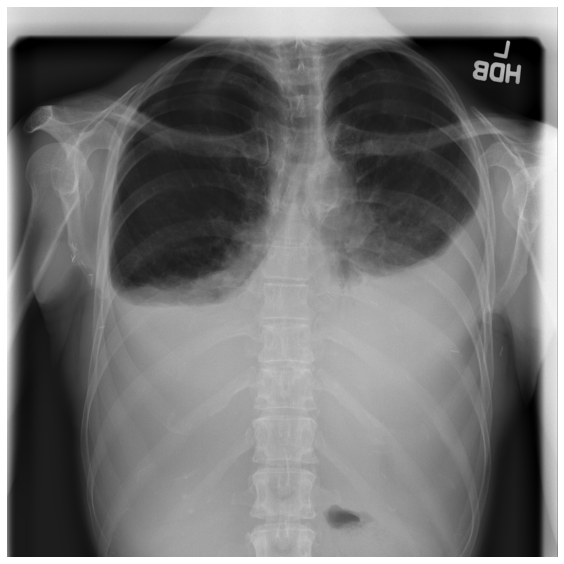

In [54]:
index = random.randint(0,len(df))
name = df['Image Index'].iloc[index]
true_label = df['Finding Labels'].iloc[index]
print(name, true_label)

fig = plt.figure(figsize=(8,8))
plt.imshow(cv2.imread(image_folder+name))
plt.axis('off')
plt.tight_layout()

In [55]:
k = [7,300]
image1 = [image_folder+name]
result, stages = function1(image1, image1)

### Output from the image encoder model (CheXNet)

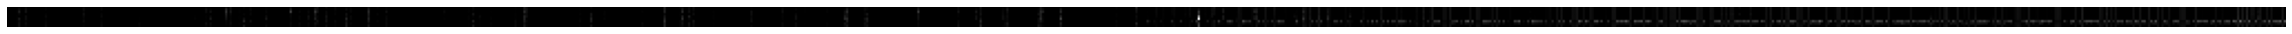

In [56]:
fig = plt.figure(figsize=(32,32))
plt.imshow(stages[0][0], cmap='gray')
plt.axis('off')
plt.tight_layout()

### Output after the encoded image is passed through a dense layer before being fed to the decoder

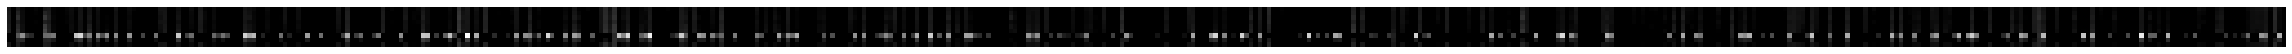

In [57]:
fig = plt.figure(figsize=(32,32))
plt.imshow(stages[1][0], cmap='gray')
plt.axis('off')
plt.tight_layout()

### Attention weights over the encoded values and the hidden states of the LSTM during text generation 

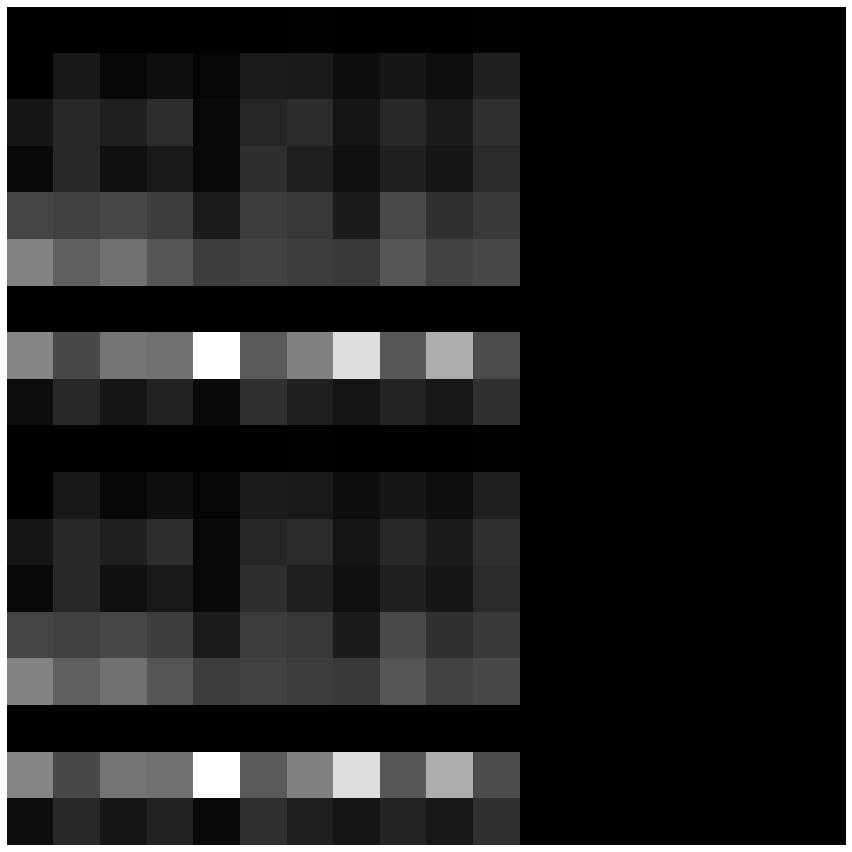

In [58]:
attention_img = np.zeros((stages[2][0].shape[1], stages[2][0].shape[1]))
for x in range(len(stages[2])):
  attention_img[:,x] = np.array(stages[2][x][0]).reshape(-1)

fig = plt.figure(figsize=(12,12))
plt.imshow(attention_img, cmap="gray")
plt.axis('off')
plt.tight_layout()

### Final Results 

## no acute cardiopulmonary abnormality . small hiatal hernia noted .

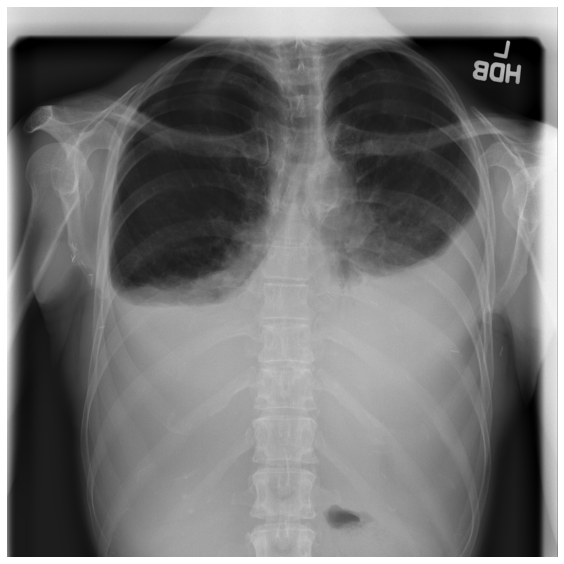

In [59]:
from IPython.display import display, Markdown, Latex

fig = plt.figure(figsize=(8,8))
plt.imshow(cv2.imread(image_folder+name))
plt.axis('off')
plt.tight_layout()

display(Markdown(f"## {result[0]}"))


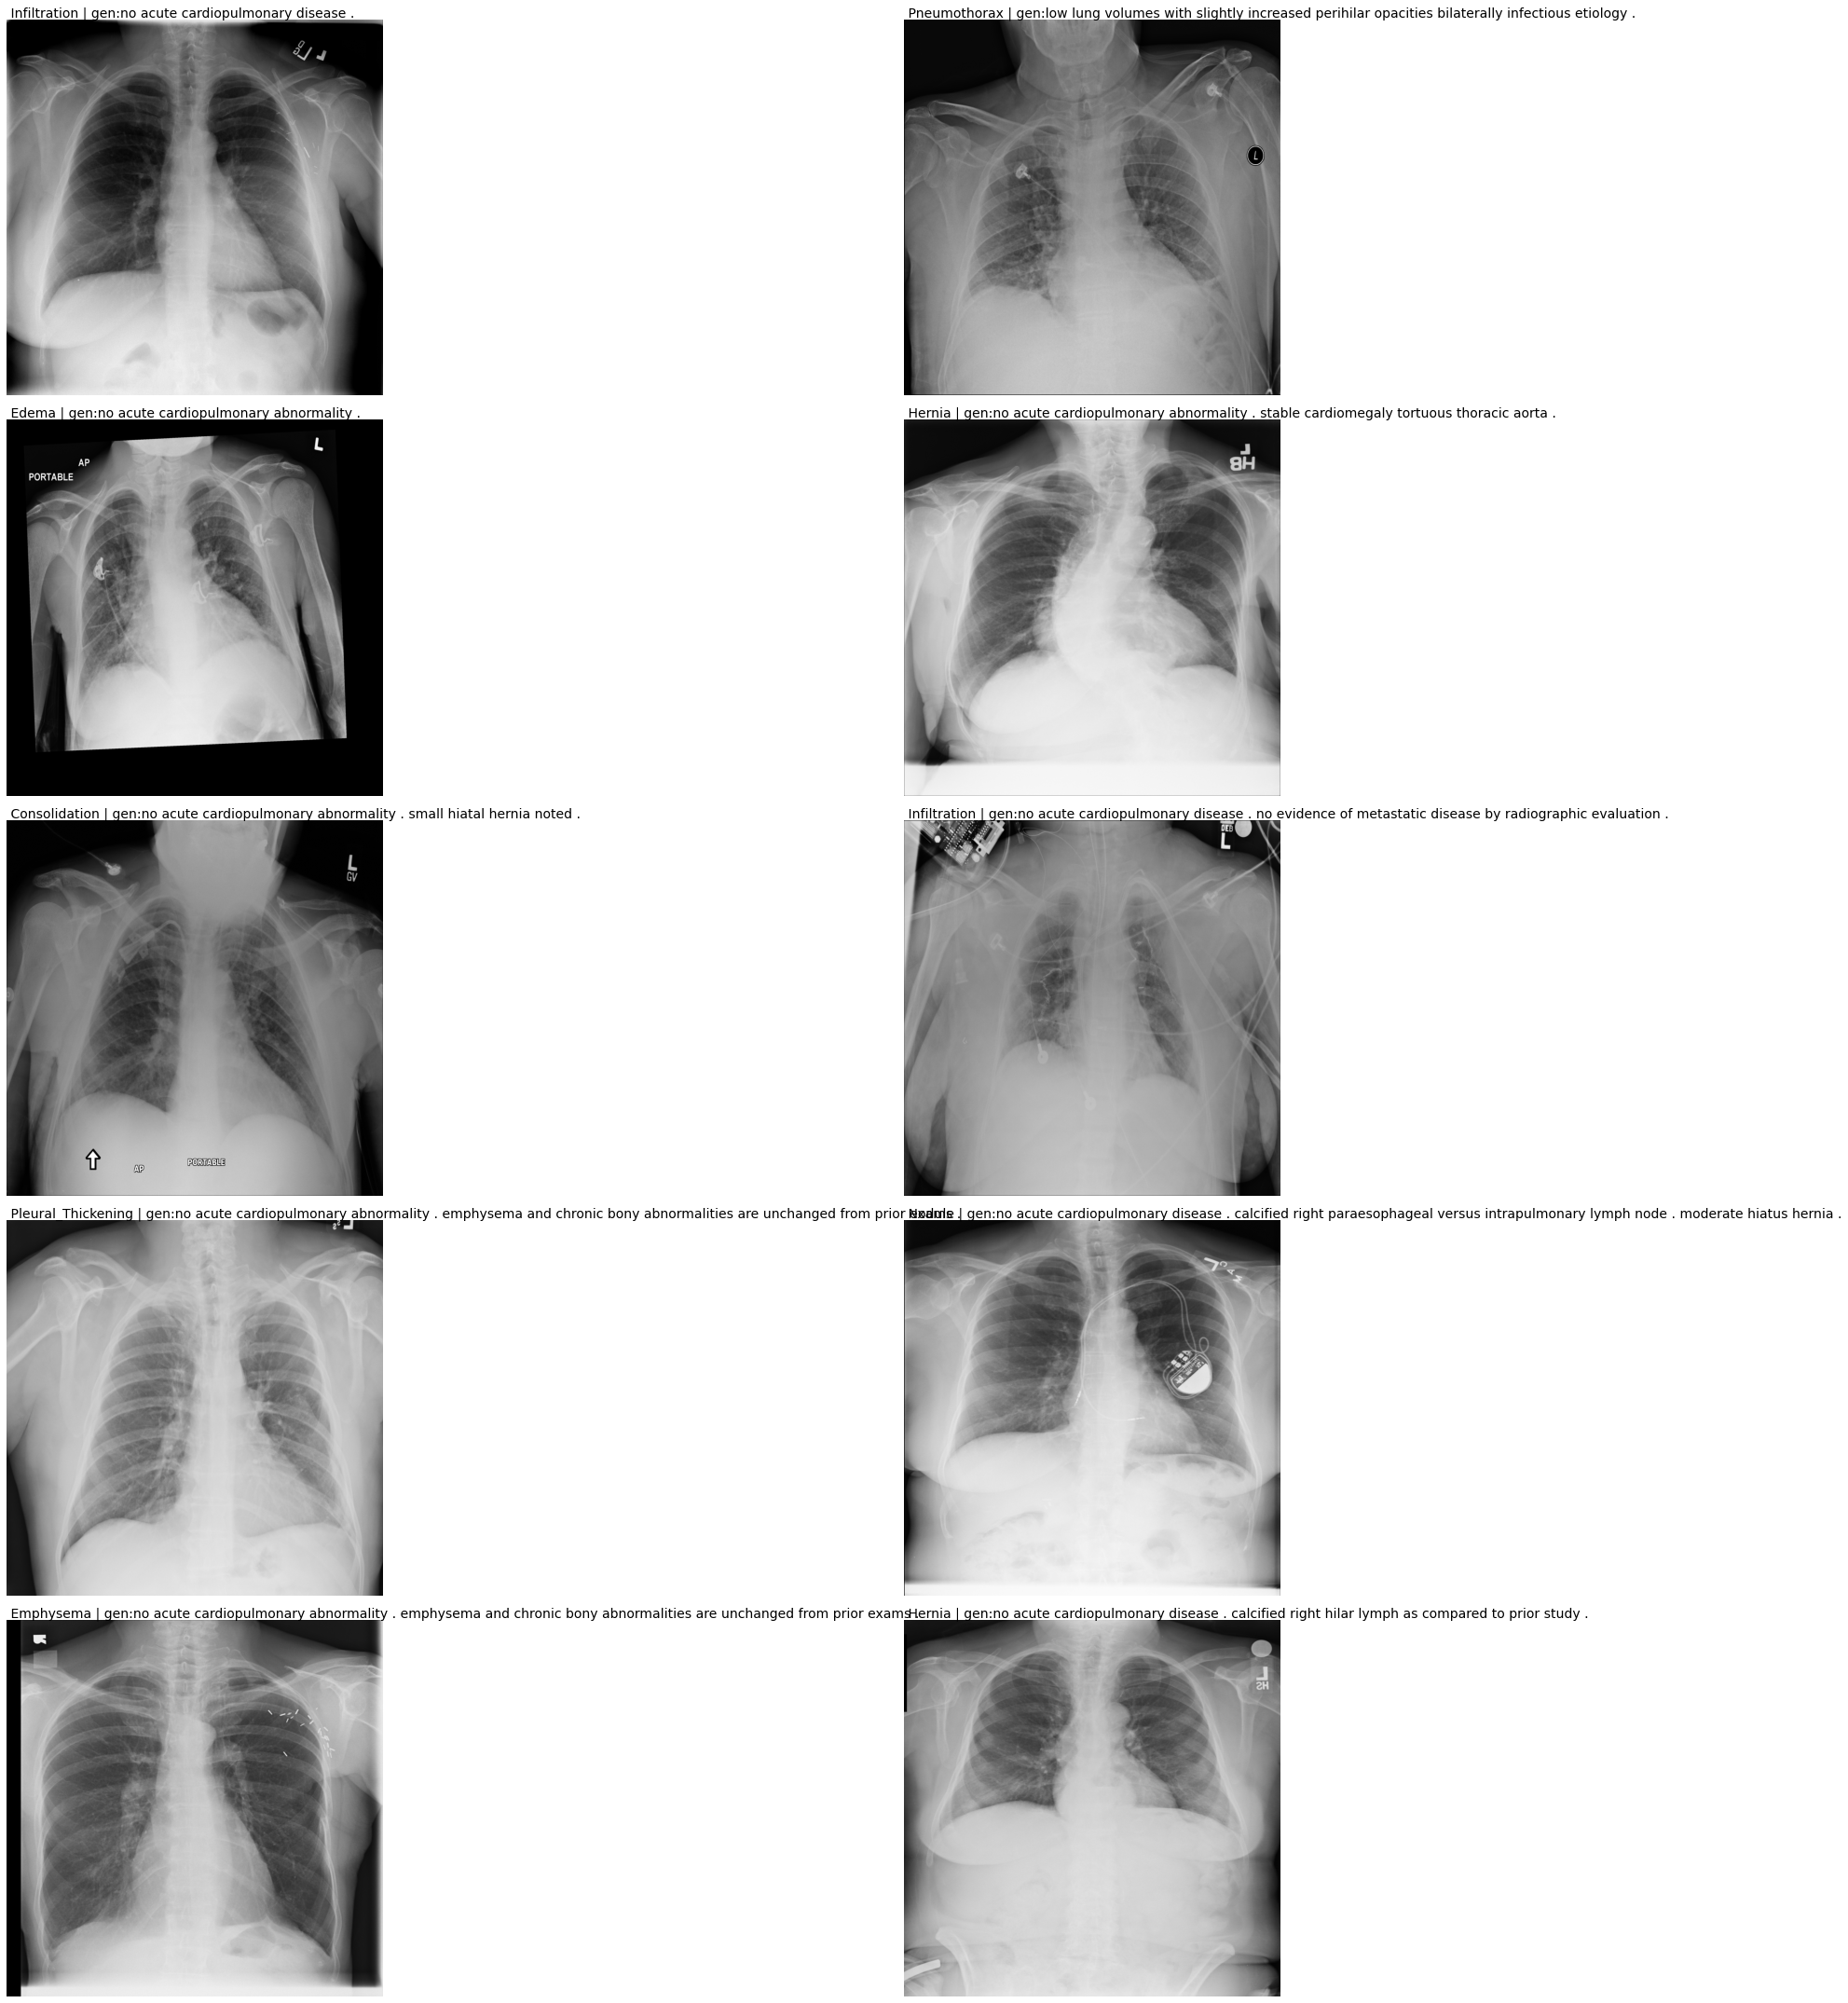

In [64]:
indexes = random.sample(range(len(train_df)), 10)
name = train_df['Image Index'].iloc[indexes]
true_label = train_df['Finding Labels'].iloc[indexes]

fig = plt.figure(figsize=(30,30))
columns = 2
rows = 5
k = [7,300]
for i in tqdm(range(1, len(indexes)+1)):
  
    image1 = [image_folder+name.iloc[i-1]]
    result, stages = function1(image1, image1)
    test_img = cv2.imread(image_folder+name.iloc[i-1])/255 

    fig.add_subplot(rows, columns, i)
    plt.imshow(test_img, cmap='gray')
    plt.text(0,-8, f" {true_label.iloc[i-1]} | gen:{result[0]}", ha='left', fontsize=14)
    plt.axis('off')
plt.tight_layout() 